In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("C:/Users/777ru/project_2/data/clean_sales_customers.csv")

df["InvoiceDate"] = pd.to_datetime(
    df["InvoiceDate"],
    format="%d-%m-%Y %H:%M"
)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [2]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)


In [3]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "Revenue": "sum"                                           # Monetary
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [4]:
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])

rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)


In [5]:
def segment_customer(row):
    if row["RFM_Score"] in ["444", "443", "434", "344"]:
        return "VIP Customers"
    elif row["F_Score"] >= 3 and row["R_Score"] >= 2:
        return "Loyal Customers"
    elif row["R_Score"] == 1:
        return "Lost Customers"
    else:
        return "At Risk"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)


In [7]:
segment_summary = rfm.groupby("Segment").agg({
    "Monetary": "mean",
    "Frequency": "mean",
    "Recency": "mean",
    "RFM_Score": "count"
}).rename(columns={"RFM_Score": "Customer_Count"})

print(segment_summary)


                    Monetary  Frequency     Recency  Customer_Count
Segment                                                            
At Risk           655.621881   1.385466   53.116114            1266
Lost Customers    650.631597   1.626384  246.980627            1084
Loyal Customers  1314.595757   3.989209   49.219424            1112
VIP Customers    6723.831575  12.076484   13.377854             876


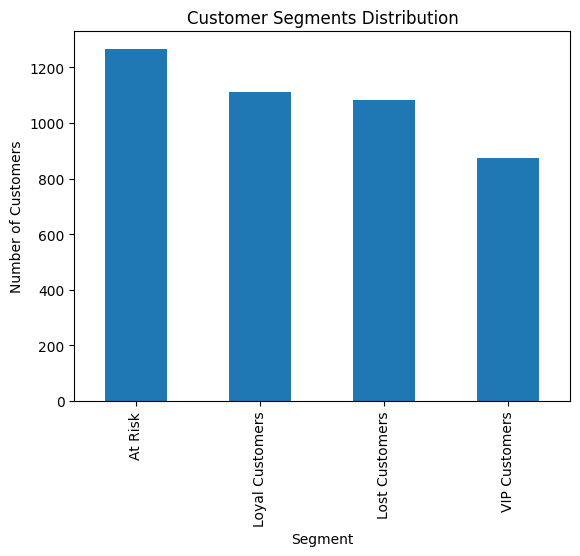

In [8]:
import matplotlib.pyplot as plt

rfm["Segment"].value_counts().plot(kind="bar")
plt.title("Customer Segments Distribution")
plt.ylabel("Number of Customers")
plt.show()


In [9]:
rfm.to_csv("rfm_customer_segments.csv")
